# Import data

In [1]:
import pandas as pd
from pennylane import numpy as np
data = pd.read_csv('dataFranklin.csv')              #Read the file
data.drop(columns='Unnamed: 0', inplace = True)     # Drup unwanted column
data.sort_values(by = ['Time', 'Longitude', 'Latitude'], ascending=[True, True, True], inplace=True)    #Reorder the rows

radius_earth = 6371000 # radius earth in meters

# Transform longitud and laititude to meters (x and y)
data['Longitude'] = radius_earth*data['Longitude']
data['Latitude'] = radius_earth*data['Latitude']


# Function to minmax scale and save linear transformation coefficients
def minmaxscale(data, min_val, max_val):
    min_dat = data.min()
    max_dat = data.max()
    
    alpha = (min_val - max_val)/(min_dat-max_dat)
    beta = min_val - alpha*min_dat
    rescaled_data = alpha*data + beta
    return rescaled_data, alpha, beta

# We now which time in the future we want to predict so we can scale this from the begginning
data['Time'], alpha_t, beta_t = minmaxscale(data['Time'], 0, 1)
data['Longitude'], alpha_x, beta_x = minmaxscale(data['Longitude'], 0, 1)
data['Latitude'], alpha_y, beta_y = minmaxscale(data['Latitude'], 0, 1)
data

,Time,Longitude,Latitude,Velocity component u,Velocity component v,Geopotential
1800,0.0,0.0,0.000000,-1.156552,0.424945,14506.583520
1770,0.0,0.0,0.016667,-0.824795,0.036197,14507.684626
1740,0.0,0.0,0.033333,-0.958053,-0.408673,14517.080724
1710,0.0,0.0,0.050000,-1.131566,-0.248520,14533.670709
1680,0.0,0.0,0.066667,-0.588818,0.034828,14539.690085
...,...,...,...,...,...,...
159359,1.0,1.0,0.933333,2.721812,11.960073,14993.198635
159329,1.0,1.0,0.950000,3.345071,13.250880,14964.349677
159299,1.0,1.0,0.966667,4.263996,14.024268,14942.841421
159269,1.0,1.0,0.983333,5.542441,13.880541,14926.838691


# Preprocessing

In [2]:
import torch

# feature lengths 
t_len = 88
x_len = 61
y_len = 30

# Agnostic code in case you have a GPU
torch_dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# Transform dataframe to numpy
np_dataset = data.to_numpy()
np_dataset

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.15655232e+00,  4.24944533e-01,  1.45065835e+04],
       [ 0.00000000e+00,  0.00000000e+00,  1.66666667e-02,
        -8.24795318e-01,  3.61968769e-02,  1.45076846e+04],
       [ 0.00000000e+00,  0.00000000e+00,  3.33333333e-02,
        -9.58053360e-01, -4.08672800e-01,  1.45170807e+04],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  9.66666667e-01,
         4.26399619e+00,  1.40242684e+01,  1.49428414e+04],
       [ 1.00000000e+00,  1.00000000e+00,  9.83333333e-01,
         5.54244054e+00,  1.38805412e+01,  1.49268387e+04],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         7.03326489e+00,  1.40146866e+01,  1.48894745e+04]])

In [3]:
from sklearn.model_selection import train_test_split

#Fit Transforming the X (time, latitude, longitude)
X = np_dataset[:10*1830, :3]
y = np_dataset[:10*1830, 3:]


# Dividing in Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, shuffle=False)

# Fit transform y_train data
y_train[:, 0], alpha_u, beta_u = minmaxscale(y_train[:, 0], -1, 1)
y_train[:, 1], alpha_v, beta_v = minmaxscale(y_train[:, 1], -1, 1)
y_train[:, 2], alpha_G, beta_G = minmaxscale(y_train[:, 2], -1, 1)

# Transform test data based on previous transfromation to avoid data leakage
y_test[:, 0] = alpha_u*y_test[:,0] + beta_u
y_test[:, 1] = alpha_v*y_test[:,1] + beta_v
y_test[:, 2] = alpha_G*y_test[:,2] + beta_G

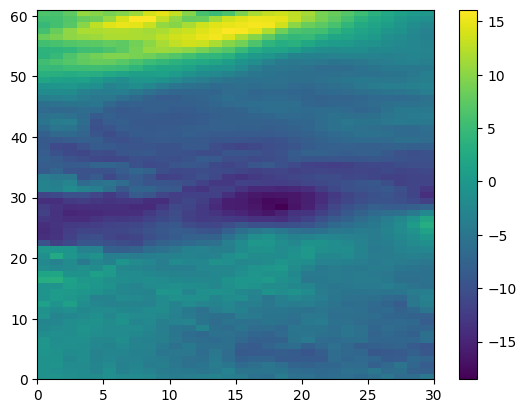

In [4]:
import matplotlib.pyplot as plt
# Lets see if this is well structured
wind_u_real = np_dataset[:61*30, 3].reshape(y_len, x_len)
plt.pcolor(wind_u_real.T)
plt.colorbar()

# Datasets

In [5]:
# Create a torch customized dataset

from torch.utils.data import Dataset, DataLoader
class HurricaneDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype = torch.float32, device = torch_dev), torch.tensor(self.y[idx], dtype = torch.float32, device = torch_dev)
        #return list(self.X[idx]), self.y[idx]
train_dataset = HurricaneDataset(X_train, y_train)
test_dataset = HurricaneDataset(X_test, y_test)

# Featrue map function 

In [7]:
import pennylane as qml
from pennylane import numpy as np
import torch
import matplotlib.pyplot as plt

def feature_map(inputs, 
                circ_wires,
                input_weights,
                weights, 
                rot_seq = [qml.RX]):
    """ 
    **Args**:
        * inputs: *Sequence*[float] features from the training dataset, should be in the form (t, x, y)
        * input_weights: *Sequence*[float] trainable parameters to linear transform the inputs (array should be twice as long as the inputs array)
        * train_weights: *Sequence*[float] trainable parameters of basic entangling layers
        * rotation_sequence: *Single or Sequence*[pennylane.ops.Operation]  if Single, use the same roation operation for each basic entangle embedding, if Sequence should be # of inputs -1 long.
    
    **Returns**:
        * Trainable feature map quantum circuit
    """

    n_qubits = len(circ_wires)

    #################################### Quantum Circuit ####################################
    # First layer of rotations (time)
    k = 0   # This will keep track on the input_weights indices
    for wire in circ_wires:
        qml.RY(input_weights[k]*inputs[0]+input_weights[k+1], wire) # time
        k+=2
    
    # If len(rot_seq) == 1 we want to multiply this so it has the disired length
    if len(rot_seq) == 1:
        rot_seq = rot_seq*3
    kk = 0

    # Layers of BasicEnganledLayers and rotations (t, x, y)
    for ii in range(1, 3):
        qml.BasicEntanglerLayers(weights=weights[kk:kk+n_qubits].unsqueeze(dim = 0), wires = circ_wires, rotation = rot_seq[ii-1])
        for wire in circ_wires:
            qml.RY(input_weights[k]*inputs[ii] + input_weights[k+1], wire)
            k+=2
    
    # Add a z constant feature for the derivatives
    qml.BasicEntanglerLayers(weights=weights[kk:kk+n_qubits].unsqueeze(dim = 0), wires = circ_wires, rotation = rot_seq[-1])
    for wire in circ_wires:
        qml.RY(input_weights[k]*0.5 + input_weights[k+1], wire)
        k+=2

# Create full circuit

In [9]:
def full_circuit(qnode, 
                 inputs,
                FM_input_weights,
                FM_train_weights,
                NN_weights,
                n_layers,
                rot_FM_seq = [qml.RX],
                rot_Train_seq = [qml.RX]):
    """ 
    **Args**:
        * qnode: *Single*[pennylane.workflow.qnode.QNode] Qnode where circuit runs
        * inputs: *Sequence*[float] features from the training dataset, should be in the form (t, x, y)
        * FM_input_weights: *Sequence*[float] trainable parameters to linear transform the inputs (array should be twice as long as the inputs array)
        * FM_train_weights: *Sequence*[float] trainable parameters of basic entangling layers on the feature map
        * FM_train_weights: *Sequence*[float] trainable parameters of basic entangling layers on the neural network
        * n_layers: *Sequence*[int] number of layers of the neural network
        * rot_FM_seq: *Single or Sequence*[pennylane.ops.Operation]  Rotations used in BasicEntangledLayers on the featuremap if Single, use the same roation operation for each basic entangle embedding, if Sequence should be # of inputs -1 long.
        * rot_NN_seq: *Single or Sequence*[pennylane.ops.Operation]  Rotations used in BasicEntangledLayers on the Neural network if Single, use the same roation operation for each basic entangle embedding, if Sequence should be # of inputs -1 long.
    
    **Returns**:
        * Expected value: Z(0)@Z(1)@...@Z(n_qubits)
    """

    n_qubits = len(qnode.device.wires) # Numbers of qubits

    # Apply featuremap
    feature_map(inputs, 
                qnode.device.wires,
                FM_input_weights,
                FM_train_weights, 
                rot_seq = rot_FM_seq)

    if len(rot_Train_seq) == 1:
        rot_Train_seq = rot_Train_seq*n_layers

    # Create NN layers
    for ii in range(n_layers):
        qml.BasicEntanglerLayers(weights=NN_weights[ii*n_qubits:(ii+1)*n_qubits].unsqueeze(0),
                                 wires = qnode.device.wires,
                                 rotation = rot_Train_seq[ii])

    ####################################### Cost Operators ##########################################
    CostOperator = qml.Z(0)
    for ii in range(1, n_qubits):
        CostOperator = CostOperator@qml.Z(ii)

    return qml.expval(CostOperator)

Lets draw the circuit to be certain of how is implemented

(<Figure size 1300x500 with 1 Axes>, <Axes: >)

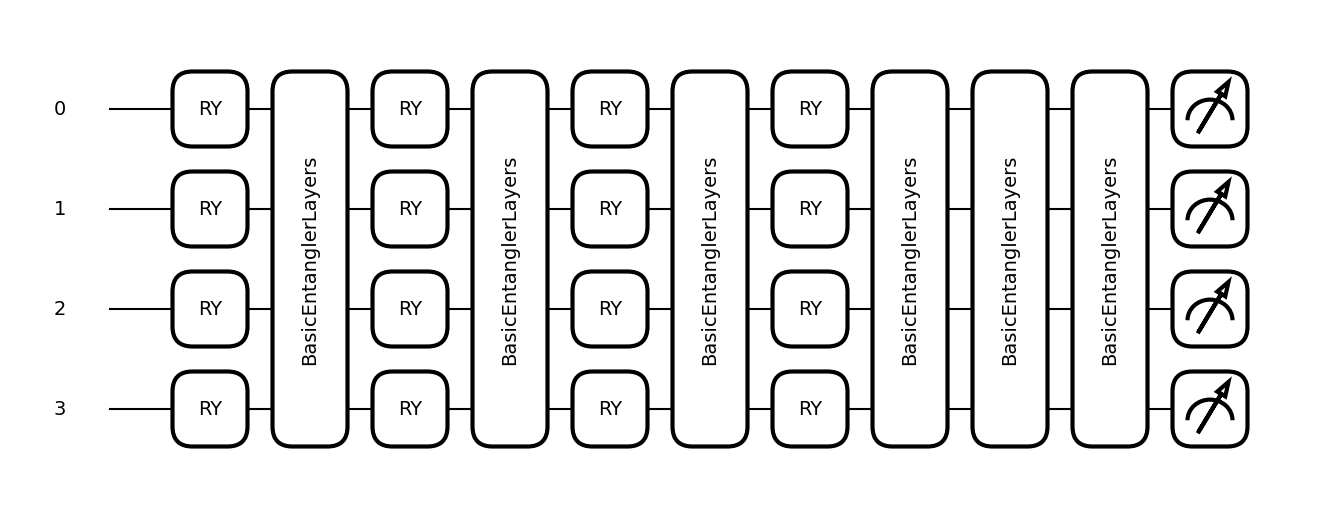

In [10]:
n_qubits = 4
n_layers = 3

full_dev = qml.device('default.qubit', wires = 4)
inp_params = torch.rand(2*4*n_qubits)
weight_params = torch.rand(3*n_qubits)
nn_params = torch.rand(n_layers*n_qubits)

full_qnode = qml.QNode(full_circuit, full_dev)

qml.draw_mpl(full_circuit, range(4))(full_qnode, torch.tensor([0, 1, 2, 3]), inp_params, weight_params, nn_params, n_layers)

# Calculate circuits expectation values

In [11]:
# We will use a circuit for each variable this will help us to evaluate everything
def get_predicts(qnodes, X_batch, FM_input_weights, 
                FM_train_weights, NN_train_weights, TL_train_weights,
                n_layers, FMrot_seq, NNrot_seq, calc_features):
    """ 
    **Args**:
        * qnode: *Single*[pennylane.workflow.qnode.QNode] Qnode where circuit runs
        * X_batch: *Sequence*[float] features from the training dataset, should be in the form (t, x, y)
        * FM_input_weights: *Sequence*[float] trainable parameters to linear transform the inputs (array should be twice as long as the inputs array)
        * FM_train_weights: *Sequence*[float] trainable parameters of basic entangling layers on the feature map
        * FM_train_weights: *Sequence*[float] trainable parameters of basic entangling layers on the neural network
        * TL_train_weights: *Sequence*[float] trainable parameters for linear transformation on output
        * n_layers: *Sequence*[int] number of layers of the neural network
        * FMrot_seq: *Single or Sequence*[pennylane.ops.Operation]  Rotations used in BasicEntangledLayers on the featuremap if Single, use the same roation operation for each basic entangle embedding, if Sequence should be # of inputs -1 long.
        * NNrot_seq: *Single or Sequence*[pennylane.ops.Operation]  Rotations used in BasicEntangledLayers on the Neural network if Single, use the same roation operation for each basic entangle embedding, if Sequence should be # of inputs -1 long.
        * calc_features: *Array*[int] which variables to calculate 0 = wind_speed_u, 1 = wind_speed_v, 2 = wind_speed_w, 3 = wind_speed_geopotential
    **Returns**:
        * Expected value: Z(0)@Z(1)@...@Z(n_qubits)
    """

    # Lets run each circuit with their own parameters
    predictions = []
    for ii in calc_features:
        res = TL_train_weights[ii][0]*qnodes[ii](qnodes[ii], X_batch, FM_input_weights[ii], 
                                              FM_train_weights[ii], NN_train_weights[ii], 
                                              n_layers, FMrot_seq, NNrot_seq) + TL_train_weights[ii][1]
        predictions.append(res)
    return predictions

# PDE residual

In [12]:
# Calculate f0 and beta from the differential equations

phi0 = 11 # hurricanes initial latitud
phi0_rad = np.pi*phi0/180 # transform to radians

Omega = 7.2921e-5
f0 = torch.tensor(2*Omega*np.sin(phi0_rad), dtype = torch.float32).to(torch_dev)
beta = torch.tensor(2*Omega*np.cos(phi0_rad)/radius_earth, dtype = torch.float32).to(torch_dev)

def pde_loss(qnodes, X_batch, FM_input_weights, FM_train_weights, NN_train_weights, TL_train_weights, n_layers, FMrot_seq, NNrot_seq):
        """ 
        **Args**:
                * qnode: *Single*[pennylane.workflow.qnode.QNode] Qnode where circuit runs
                * X_batch: *Sequence*[float] features from the training dataset, should be in the form (t, x, y)
                * FM_input_weights: *Sequence*[float] trainable parameters to linear transform the inputs (array should be twice as long as the inputs array)
                * FM_train_weights: *Sequence*[float] trainable parameters of basic entangling layers on the feature map
                * FM_train_weights: *Sequence*[float] trainable parameters of basic entangling layers on the neural network
                * TL_train_weights: *Sequence*[float] trainable parameters for linear transformation on output
                * n_layers: *Sequence*[int] number of layers of the neural network
                * FMrot_seq: *Single or Sequence*[pennylane.ops.Operation]  Rotations used in BasicEntangledLayers on the featuremap if Single, use the same roation operation for each basic entangle embedding, if Sequence should be # of inputs -1 long.
                * NNrot_seq: *Single or Sequence*[pennylane.ops.Operation]  Rotations used in BasicEntangledLayers on the Neural network if Single, use the same roation operation for each basic entangle embedding, if Sequence should be # of inputs -1 long.
        
        **Returns**:
                * Navier stokes residual: *Sequence[float]*
        """
        # Num qubitsF
        n_qubits = len(qnodes[0].device.wires)
        
        # U and V components of wind speed val
        u, v, w, _ = get_predicts(qnodes, X_batch, FM_input_weights, 
                FM_train_weights, NN_train_weights, TL_train_weights,
                n_layers, FMrot_seq, NNrot_seq)

        # partials of t
        par_t_u = 0
        par_t_v = 0
        for ii in range(n_qubits):
                # Zeros vec
                zeros_vec = torch.zeros(FM_input_weights.shape, dtype = torch.float32, device = torch_dev)
                zeros_vec[:, 2*ii+1] = torch.pi/2       #element to modify

                # Plus and minus shifts
                plus_train_FM = FM_input_weights+zeros_vec
                minus_train_FM = FM_input_weights-zeros_vec

                # calculate
                pos_term_u, pos_term_v, _, _ = get_predicts(qnodes, X_batch, plus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq, [0, 1])
                neg_term_u, neg_term_v, _, _ = get_predicts(qnodes, X_batch, minus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq, [0, 1]) 

                # Partial accumulations
                par_t_u += (FM_input_weights[0][2*ii]/2)*(pos_term_u - neg_term_u)
                par_t_v += (FM_input_weights[1][2*ii]/2)*(pos_term_v - neg_term_v)

        # partials of x 
        par_x_u = 0
        par_x_v = 0
        par_x_G = 0
        for ii in range(n_qubits):
                # Zeros vec
                zeros_vec = torch.zeros(FM_input_weights.shape, dtype = torch.float32, device = torch_dev)
                zeros_vec[:, 2*n_qubits + 2*ii+1] = torch.pi/2       #element to modify

                # Plus and minus shifts
                plus_train_FM = FM_input_weights+zeros_vec
                minus_train_FM = FM_input_weights-zeros_vec

                # calculate
                pos_term_u, pos_term_v, _, pos_term_G = get_predicts(qnodes, X_batch, plus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq, [0, 1, 3])
                neg_term_u, neg_term_v, _, neg_term_G = get_predicts(qnodes, X_batch, minus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq, [0, 1, 3]) 

                par_x_u += (FM_input_weights[0][2*n_qubits + 2*ii]/2)*(pos_term_u - neg_term_u)
                par_x_v += (FM_input_weights[1][2*n_qubits + 2*ii]/2)*(pos_term_v - neg_term_v)
                par_x_G += (FM_input_weights[3][2*n_qubits + 2*ii]/2)*(pos_term_G - neg_term_G)

        # partials of y 
        par_y_u = 0
        par_y_v = 0
        par_y_G = 0
        for ii in range(n_qubits):
                # Zeros vec
                zeros_vec = torch.zeros(FM_input_weights.shape, dtype = torch.float32, device = torch_dev)
                zeros_vec[:, 4*n_qubits + 2*ii+1] = torch.pi/2       #element to modify

                # Plus and minus shifts
                plus_train_FM = FM_input_weights+zeros_vec
                minus_train_FM = FM_input_weights-zeros_vec

                # calculate
                pos_term_u, pos_term_v, _, pos_term_G = get_predicts(qnodes, X_batch, plus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq, [0, 1, 3])
                neg_term_u, neg_term_v, _, neg_term_G = get_predicts(qnodes, X_batch, minus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq, [0, 1, 3]) 
                
                par_y_u += (FM_input_weights[0][4*n_qubits + 2*ii]/2)*(pos_term_u - neg_term_u)
                par_y_v += (FM_input_weights[1][4*n_qubits + 2*ii]/2)*(pos_term_v - neg_term_v)
                par_y_G += (FM_input_weights[3][4*n_qubits + 2*ii]/2)*(pos_term_G - neg_term_G)

        # Partial of p
        par_p_u = 0
        par_p_v = 0
        par_p_w = 0

        for ii in range(n_qubits):
                # Zeros vec
                zeros_vec = torch.zeros(FM_input_weights.shape, dtype = torch.float32, device = torch_dev)
                zeros_vec[:, 6*n_qubits + 2*ii+1] = torch.pi/2       #element to modify

                # Plus and minus shifts
                plus_train_FM = FM_input_weights+zeros_vec
                minus_train_FM = FM_input_weights-zeros_vec

                # calculate
                pos_term_u, pos_term_v, pos_term_w, _ = get_predicts(qnodes, X_batch, plus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq, [0, 1, 2])
                neg_term_u, neg_term_v, neg_term_w, _= get_predicts(qnodes, X_batch, minus_train_FM, 
                                                        FM_train_weights, NN_train_weights, TL_train_weights,
                                                        n_layers, FMrot_seq, NNrot_seq, [0, 1, 2]) 
                
                par_p_u += (FM_input_weights[0][6*n_qubits + 2*ii]/2)*(pos_term_u - neg_term_u)
                par_p_v += (FM_input_weights[1][6*n_qubits + 2*ii]/2)*(pos_term_v - neg_term_v)
                par_p_w += (FM_input_weights[2][6*n_qubits + 2*ii]/2)*(pos_term_w - neg_term_w)

        # calculate the square of each equation
        sq1 = torch.abs((par_t_u*alpha_t + 
                                    ((u - beta_u)/alpha_u)*par_x_u + 
                                    ((v - beta_v)/alpha_v)*par_y_u + 
                                    w*par_p_u)/alpha_u - 
                                    (f0 + beta*((X_batch[2]-beta_y)/alpha_y))*((v-beta_v)/alpha_v) + 
                                    par_x_G*alpha_x/alpha_G)**2
        sq2 = torch.abs((par_t_v*alpha_t + 
                                    ((u - beta_u)/alpha_u)*par_x_v + 
                                    ((v - beta_v)/alpha_v)*par_y_v + 
                                    w*par_p_v)/alpha_v +
                                    (f0 + beta*((X_batch[2]-beta_y)/alpha_y))*((u-beta_u)/alpha_u)+ 
                                    par_y_G*alpha_y/alpha_G)**2
        sq3 = torch.abs(par_x_u*alpha_x/alpha_u + par_y_v*alpha_y/alpha_v + par_p_w)**2
        
        
        return torch.mean(sq1 + sq2 + sq3)

# Cost function

In [14]:
from tqdm.auto import tqdm
import time

# Create cost function 
def cost_fn(qnodes, X_batch, y_batch, n_layers, weights, gamma, FMrot_seq, NNrot_seq, epoch):
    n_qubits = len(qnodes[0].device.wires)

    # Indx lengths
    idx0 = 8*n_qubits
    idx1 = 3*n_qubits
    idx2 = n_layers*n_qubits
    idx3 = 2
    
    # Weights split u
    FM_input_weights = weights[:4*idx0].reshape(4, idx0)
    FM_train_weights = weights[4*idx0:4*(idx0 + idx1)].reshape(4, idx1)
    NN_train_weights = weights[4*(idx0 + idx1):4*(idx0 + idx1 + idx2)].reshape(4, idx2)
    TL_train_weights = weights[4*(idx0 + idx1 + idx2):4*(idx0 + idx1 + idx2 + idx3)].reshape(4, idx3)

    # Transpose X and y batches
    X_batch = torch.t(X_batch)
    y_batch = torch.t(y_batch)

    global cte_data

    # If gamma = 1 we don't need to calculate the data loss
    if gamma != 1:
        predict_u, predict_v, _, predict_G = get_predicts(qnodes, X_batch, FM_input_weights, 
                    FM_train_weights, NN_train_weights, TL_train_weights,
                    n_layers, FMrot_seq, NNrot_seq)
        loss_u = ((predict_u - y_batch[0])*alpha_u)**2
        loss_v = ((predict_v - y_batch[1])*alpha_v)**2
        loss_G = ((predict_G - y_batch[2])*alpha_G)**2
        static_loss = torch.mean(torch.sqrt(y_batch[0]**2 + y_batch[1]**2)*(loss_u + loss_v + loss_G))
        if epoch == 0:
            cte_data = static_loss.item()
    else:
        static_loss = 1
        cte_data = 1

    global cte_phys
    
    # If gamma = 0 we don't need to calculate the physics loss
    if gamma != 0:
        physics_loss = pde_loss(qnodes, X_batch, FM_input_weights, FM_train_weights, NN_train_weights, TL_train_weights, n_layers,  FMrot_seq, NNrot_seq)
        if epoch == 0:
          cte_phys = physics_loss.item()
    else:
      physics_loss = torch.tensor(0)
      cte_phys = 1
        
    # Calculate the physics and data loss (return them individually)
    print(f'Epoch: {epoch} | Physics Loss: {physics_loss.item()/cte_phys} | Static Loss: {static_loss.item()/cte_data} | Cte Phys: {cte_phys} | Cte Data: {cte_data}')

    # Total cost
    cost =  (1-gamma)*static_loss/cte_data +  gamma*physics_loss/cte_phys
    return cost

c:\Users\gilbe\anaconda3\envs\QuantumAI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataloader

In [15]:
# Create dataloaders 
BATCH_SIZE = 61*30*5
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle = False)

 # Training NN (gamma = 0)

In [ ]:
from tqdm.auto import tqdm
import torch
import torch.optim as optim
import random

# Create quantum circuit qnode and parameters
n_layers = 4
n_qubits = 4

# Training lengths
len0 = 8*n_qubits
len1 = 3*n_qubits
len2 = n_layers*n_qubits
len3 = 2

# Initialize random parameters
params = torch.rand(4*(len0+len1+len2+len3), dtype = torch.float32).to(torch_dev)
params.requires_grad = True

print(params)

# Create qnodes
device = qml.device('default.qubit.torch', 
                    wires = n_qubits,
                    torch_device = torch_dev)
qnode_u = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_v = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_w = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_G = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')

qnodes = [qnode_u, qnode_v, qnode_w, qnode_G]

def torch_optimize(qnodes, X_train, X_test, params, epochs, FMrot_seq, NNrot_seq, gamma, verbose = False):
    train_cost_vec = []
    test_cost_vec = []
    best_cost = 1e10
    # Optimizer
    opt = torch.optim.LBFGS([params], history_size = 200)
    for i in range(epochs):
        avg_train_cost = 0
        # Calculate loss and optimize from train batch
        for X_batch, y_batch in tqdm(X_train):
            def closure():
                opt.zero_grad()
                cost = cost_fn(qnodes, X_batch, y_batch, n_layers, params, gamma, FMrot_seq, NNrot_seq, i)
                if cost.requires_grad:
                    cost.backward()
                return cost
            avg_train_cost += opt.step(closure)

        avg_train_cost /= len(X_train)

        # Calculate loss from test batch
        avg_test_cost = 0
        with torch.no_grad():   
            for X_batch, y_batch in X_test:
                avg_test_cost += cost_fn(qnodes, X_batch, y_batch, n_layers, params, gamma, FMrot_seq, NNrot_seq, i+1)
        avg_test_cost /= len(X_test)
        test_cost_vec.append(avg_test_cost.item())
        
        # Print status
        if verbose and i%1 == 0:
            print(f"Epoch: {i} | Train loss: {avg_train_cost} | Test loss: {avg_test_cost}")
        train_cost_vec.append(avg_train_cost.item())

        # Save parameters, train and test cost
        if train_cost_vec[-1] < best_cost:
            torch.save(params, 'best_params_0.pth')
            best_cost = train_cost_vec[-1]
        torch.save(torch.tensor(train_cost_vec), 'train_cost_0_00.pth')
        torch.save(torch.tensor(test_cost_vec), 'test_cost_0_00.pth')

    return train_cost_vec, test_cost_vec, params

n_epochs = 41
gamma = 0

train_cost, test_cost, new_params= torch_optimize(qnodes, train_dataloader, test_dataloader, params, n_epochs, [qml.RX], [qml.RX], gamma, True)
print(new_params)

# Train NN (gamma = 0.05)

In [ ]:
from tqdm.auto import tqdm
import torch
import torch.optim as optim
import random

# Create quantum circuit qnode and parameters
n_layers = 4
n_qubits = 4

# Training lengths
len0 = 8*n_qubits
len1 = 3*n_qubits
len2 = n_layers*n_qubits
len3 = 2

# Initialize random parameters
params = torch.rand(4*(len0+len1+len2+len3), dtype = torch.float32).to(torch_dev)
params.requires_grad = True

print(params)

# Create qnodes
device = qml.device('default.qubit.torch', 
                    wires = n_qubits,
                    torch_device = torch_dev)
qnode_u = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_v = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_w = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_G = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')

qnodes = [qnode_u, qnode_v, qnode_w, qnode_G]

def torch_optimize(qnodes, X_train, X_test, params, epochs, FMrot_seq, NNrot_seq, gamma, verbose = False):
    train_cost_vec = []
    test_cost_vec = []
    best_cost = 1e10
    # Optimizer
    opt = torch.optim.LBFGS([params], history_size = 200)
    for i in range(epochs):
        avg_train_cost = 0
        # Calculate loss and optimize from train batch
        for X_batch, y_batch in tqdm(X_train):
            def closure():
                opt.zero_grad()
                cost = cost_fn(qnodes, X_batch, y_batch, n_layers, params, gamma, FMrot_seq, NNrot_seq, i)
                if cost.requires_grad:
                    cost.backward()
                return cost
            avg_train_cost += opt.step(closure)

        avg_train_cost /= len(X_train)

        # Calculate loss from test batch
        avg_test_cost = 0
        with torch.no_grad():   
            for X_batch, y_batch in X_test:
                avg_test_cost += cost_fn(qnodes, X_batch, y_batch, n_layers, params, gamma, FMrot_seq, NNrot_seq, i+1)
        avg_test_cost /= len(X_test)
        test_cost_vec.append(avg_test_cost.item())
        
        # Print status
        if verbose and i%1 == 0:
            print(f"Epoch: {i} | Train loss: {avg_train_cost} | Test loss: {avg_test_cost}")
        train_cost_vec.append(avg_train_cost.item())

        # Save parameters, train and test cost
        if train_cost_vec[-1] < best_cost:
            torch.save(params, 'best_params_0_05.pth')
            best_cost = train_cost_vec[-1]
        torch.save(torch.tensor(train_cost_vec), 'train_cost_0_05.pth')
        torch.save(torch.tensor(test_cost_vec), 'test_cost_0_05.pth')

    return train_cost_vec, test_cost_vec, params

n_epochs = 41
gamma = 0.05

train_cost, test_cost, new_params= torch_optimize(qnodes, train_dataloader, test_dataloader, params, n_epochs, [qml.RX], [qml.RX], gamma, True)
print(new_params)

# Train NN (gamma = 0.5)

In [ ]:
from tqdm.auto import tqdm
import torch
import torch.optim as optim
import random

# Create quantum circuit qnode and parameters
n_layers = 4
n_qubits = 4

# Training lengths
len0 = 8*n_qubits
len1 = 3*n_qubits
len2 = n_layers*n_qubits
len3 = 2

# Initialize random parameters
params = torch.rand(4*(len0+len1+len2+len3), dtype = torch.float32).to(torch_dev)
params.requires_grad = True

print(params)

# Create qnodes
device = qml.device('default.qubit.torch', 
                    wires = n_qubits,
                    torch_device = torch_dev)
qnode_u = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_v = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_w = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')
qnode_G = qml.QNode(full_circuit, device = device, interface = 'torch', diff_method = 'best')

qnodes = [qnode_u, qnode_v, qnode_w, qnode_G]

def torch_optimize(qnodes, X_train, X_test, params, epochs, FMrot_seq, NNrot_seq, gamma, verbose = False):
    train_cost_vec = []
    test_cost_vec = []
    best_cost = 1e10
    # Optimizer
    opt = torch.optim.LBFGS([params], history_size = 200)
    for i in range(epochs):
        avg_train_cost = 0
        # Calculate loss and optimize from train batch
        for X_batch, y_batch in tqdm(X_train):
            def closure():
                opt.zero_grad()
                cost = cost_fn(qnodes, X_batch, y_batch, n_layers, params, gamma, FMrot_seq, NNrot_seq, i)
                if cost.requires_grad:
                    cost.backward()
                return cost
            avg_train_cost += opt.step(closure)

        avg_train_cost /= len(X_train)

        # Calculate loss from test batch
        avg_test_cost = 0
        with torch.no_grad():   
            for X_batch, y_batch in X_test:
                avg_test_cost += cost_fn(qnodes, X_batch, y_batch, n_layers, params, gamma, FMrot_seq, NNrot_seq, i+1)
        avg_test_cost /= len(X_test)
        test_cost_vec.append(avg_test_cost.item())
        
        # Print status
        if verbose and i%1 == 0:
            print(f"Epoch: {i} | Train loss: {avg_train_cost} | Test loss: {avg_test_cost}")
        train_cost_vec.append(avg_train_cost.item())

        # Save parameters, train and test cost
        if train_cost_vec[-1] < best_cost:
            torch.save(params, 'best_params_0_5.pth')
            best_cost = train_cost_vec[-1]
        torch.save(torch.tensor(train_cost_vec), 'train_cost_0_5.pth')
        torch.save(torch.tensor(test_cost_vec), 'test_cost_0_5.pth')

    return train_cost_vec, test_cost_vec, params

n_epochs = 41
gamma = 0.5

train_cost, test_cost, new_params= torch_optimize(qnodes, train_dataloader, test_dataloader, params, n_epochs, [qml.RX], [qml.RX], gamma, True)
print(new_params)